## 4.5　学習アルゴリズムの実装

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../input/deeplearningfromscratchmaster/deep-learning-from-scratch-master')

In [3]:
from common.functions import *
from common.gradient import numerical_gradient

### 4.5.1　2 層ニューラルネットワークのクラス

$784 \times 100 \times 10$ の 2 層ネットワークのクラスを作成する。

In [4]:
class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(y, axis=1)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

`loss_W` は損失関数なので、`numerical_gradient` に `loss_W` と `W, b` を与えればいい。<br>
`loss` には `predict` が入っているので、この時に順伝播を行っている。

In [5]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['W2'].shape)

(784, 100)
(100, 10)


In [6]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

print(x.shape)
print(t.shape)

(100, 784)
(100, 10)


行数 100 はバッチサイズである。

In [7]:
grads = net.numerical_gradient(x,t)

print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


今回は単純な偏微分の計算 `numerical_gradient` で勾配を求めたが、これには時間がかかる。<br>
そのため、誤差逆伝播法という使って、勾配の求める処理を高速にしていく。

### 4.5.3 ミニバッチ学習の実装

In [8]:
from ch04.two_layer_net import TwoLayerNet

In [9]:
x_train = np.load('../input/load-mnist/load_mnist/normalize=True, one_hot_label=True/x_train.npy')
t_train = np.load('../input/load-mnist/load_mnist/normalize=True, one_hot_label=True/t_train.npy')
x_test = np.load('../input/load-mnist/load_mnist/normalize=True, one_hot_label=True/x_test.npy')
t_test = np.load('../input/load-mnist/load_mnist/normalize=True, one_hot_label=True/t_test.npy')

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [10]:
train_loss_list = []

In [11]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

In [12]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

`grad` には `grads['W1'], grads['b1'], grads['W2'], grads['b2']` が代入されている。

### 4.5.3　テストデータで評価

In [13]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

In [14]:
train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)

In [15]:
print(train_size)
print(batch_size)
print(iter_per_epoch)

60000
100
600.0


`iter_per_epoch` は、1 エポックあたりの繰り返し数である。

In [16]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('train acc, test acc | ' + str(train_acc) + ', ' + str(test_acc))

train acc, test acc | 0.0993, 0.1031
train acc, test acc | 0.7851833333333333, 0.794
train acc, test acc | 0.8777166666666667, 0.8826
train acc, test acc | 0.899, 0.9021
train acc, test acc | 0.90845, 0.9107
train acc, test acc | 0.9140333333333334, 0.9159
train acc, test acc | 0.9199666666666667, 0.9216
train acc, test acc | 0.9237833333333333, 0.925
train acc, test acc | 0.9273333333333333, 0.9294
train acc, test acc | 0.9302, 0.9321
train acc, test acc | 0.9344833333333333, 0.9365
train acc, test acc | 0.9368166666666666, 0.9357
train acc, test acc | 0.9392666666666667, 0.9394
train acc, test acc | 0.9414, 0.9419
train acc, test acc | 0.9434666666666667, 0.9431
train acc, test acc | 0.9458333333333333, 0.9447
train acc, test acc | 0.94795, 0.9463


繰り返し数 `i` が 1 エポック相当になる度に、スコアが出力される。

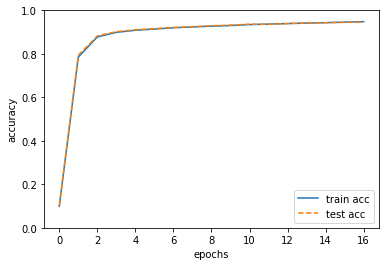

In [17]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()